<center><h1>Neuroscience Final Project</h1></center>
<center><h2>Deep Q Networks</h2></center>

In this notebook, we are going to get familiar with Deep Q Networks. You have been introduced to Reinforcement Learning in the course. Deep Q Networks are an entension of Reinforcement Learning where we incorporate Deep Neural Networks in our policy enhacement procedure.

We also implement an Agent in an online learning environment, meaning that the agent has no initial memory of the rewards in each state. We go through the environment based on our policy and store the observed rewards and corresponding state in the memory of the agent

Finally, we utilize the Agent in a practical Maze Solving problem. The agent is prompted to iterate the maze from a defined starting point to an ending point, maximing the profit from the total route.

**Name** :

**Student ID**:

## Importing the necessary packages

In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random

## Creating the Deep Q Network

In [2]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*tuple(input_dims), fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Calculate the forward pass. Use Proper non-linear activation function between the linear layers
        hid1 = self.fc1(state)
        hid1 = T.relu(hid1)
        hid2 = self.fc2(hid1)
        hid2 = T.relu(hid2)
        actions = self.fc3(hid2)

        # action_probs = torch.softmax(actions, dim=-1) #????

        return actions

## Creating the Agent

In [3]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-5):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0

        # Create an instance of te Deep Q network with 256 neurons in each of its hidden layers
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims= tuple(input_dims), fc1_dims=256, fc2_dims=256)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)


    # Store one episode alongside its reward, state, next_state
    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1


    # Choose the best action with probability (1 - epsilon), otherwise choose a random direction from the action space
    # The best action is defined as the maximum output of the Deep Q Network
    def choose_action(self, state):
        state = T.tensor(state, dtype=T.float).to(self.Q_eval.device)

        if random.uniform(0, 1) > self.epsilon:
        # Get the action with the highest Q-value
            actions = self.Q_eval(state)
            action = T.argmax(actions).item()
        else:
            action = random.choice(self.action_space)

        return action

    # Train the Deep Q Network based on the new observations
    # The network must learn the target Q values through regression
    def learn(self):
        # Simply ignore the training phase if there is not enough memory stored yet
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        # Choose a random batch of data from the memory
        batch = np.array(random.sample(range(min(self.mem_cntr, self.mem_size)), self.batch_size))

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)
        # Current state Q-value as predicted by the network

        # Note to filter the matrix to only q-values corresponding to our "action_batch"
        q_eval = self.Q_eval(state_batch)[np.arange(self.batch_size), action_batch]

        # Next state Q-value as predicted by the network for all possible next actions
        q_next = self.Q_eval(new_state_batch)
        # The target Q-value of our current state with a discount factor of gamma
        q_target = reward_batch + (self.gamma * T.max(q_next, dim=1)[0])

        # Make the network learn this target Q-value via a proper definitio of loss function
        loss = self.Q_eval.loss(q_eval, q_target)
        loss.backward()
        self.Q_eval.optimizer.step()
        # print("epsilon is :", self.epsilon)
        self.iter_cntr += 1

        # Reduce the epsilon by its decay factor if possible
        if self.epsilon > self.eps_min:
            self.epsilon -= self.eps_dec
            # self.epsilon *= 0.9999

## Working with the Maze environment

In [8]:
from maze import MazeEnvironment
maze1 = MazeEnvironment(np.load('./mazes/maze1.npy').shape[0], maze_path = './mazes/maze1.npy')
# x = np.load('./mazes/maze1.npy')
# print(x.shape)
rand_maze = MazeEnvironment()

In [10]:
# from maze.py import MazeEnvironment # changed maze.py to maze to import in colab
import warnings
warnings.filterwarnings('ignore')

# Create a maze environment
# You can create a new one or use the files stored in directory mazes to load a maze
env = maze1
# env = rand_maze
agent = Agent(gamma=0.9, epsilon=1.0, lr=0.001, input_dims=[2] , batch_size=8, n_actions=4, eps_end=0.1, eps_dec=1e-4)
scores = []
n_games = 100

for i in range(n_games):

    score = 0
    done = False
    observation = env.reset()
    counter = 0
    j = 0
    while not done:
        counter += 1
        # If performed 1000 moves and didn't finish the maze, reset the environment
        if (counter == 1000):
            # print('broken')
            break
            # counter = 0
            # score = 0
            # observation = env.reset()

        # Make the agent choose an action
        action = agent.choose_action(observation)

        # Retrieve the reward and next_state from the envirinment
        observation_, reward, done = env.step(action)

        score += reward

        # Store the current episode in the memory
        agent.store_transition(observation, action, reward, observation_, done)

        # Learn the current episode
        agent.learn()

        # Change the next state to the current state
        observation = observation_
        if done:
            if agent.epsilon > agent.eps_min:
                agent.epsilon -= agent.eps_dec
            # self.epsilon *= 0.9999
        j += 1
        if j > 100000:
          print("middle reward is:", score)
          break

    scores.append(score)

    avg_score = np.mean(scores[-10:])

    print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

episode  0 score 766.00 average score 766.00 epsilon 0.90
episode  1 score 601.00 average score 683.50 epsilon 0.80
episode  2 score 6153.00 average score 2506.67 epsilon 0.70
episode  3 score 3971.00 average score 2872.75 epsilon 0.65
episode  4 score 7693.00 average score 3836.80 epsilon 0.58
episode  5 score 5240.00 average score 4070.67 epsilon 0.54
episode  6 score 5295.00 average score 4245.57 epsilon 0.49
episode  7 score 2810.00 average score 4066.12 epsilon 0.46
episode  8 score 2267.00 average score 3866.22 epsilon 0.45
episode  9 score 5061.00 average score 3985.70 epsilon 0.41
episode  10 score 3602.00 average score 4269.30 epsilon 0.39
episode  11 score 3620.00 average score 4571.20 epsilon 0.36
episode  12 score 4440.00 average score 4399.90 epsilon 0.33
episode  13 score 6257.00 average score 4628.50 epsilon 0.29
episode  14 score 3677.00 average score 4226.90 epsilon 0.27
episode  15 score 2903.00 average score 3993.20 epsilon 0.25
episode  16 score 3408.00 average scor

100


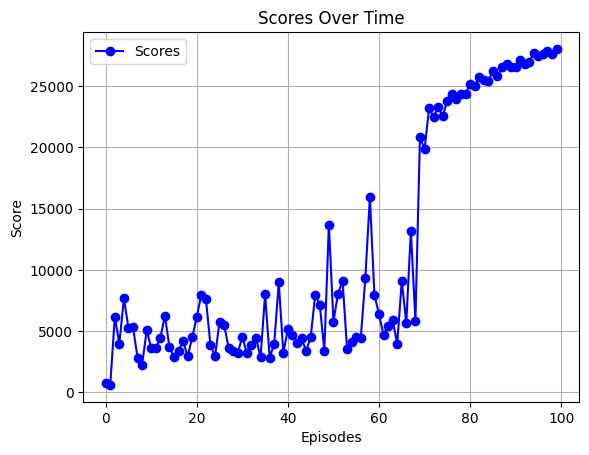

In [11]:

import matplotlib.pyplot as plt

print(len(scores))

plt.plot(scores, marker='o', linestyle='-', color='b', label='Scores')

# Adding title and labels
plt.title('Scores Over Time')
plt.xlabel('Episodes')
plt.ylabel('Score')

# Adding a grid
plt.grid(True)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

## Report

Try to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score.

Grading will not be based on the best scores. However, higher scores can bring bonus grade!




Plot the incrementation of your score through n games and try to justify the patterns.

as we can see in the plot, the model learns to maximize its score after about 70 games played. So from 70th game scores have a big jump to above 20k and from then, the scores the agent gets increase almost linearly. The peak score was in the last game that the agent scored 28046 points in the default maze (maze1.npy in the mazes folder). the hyperparameters were as follows:
- gamma : 0.99
- epsilon: 1.0
- epsilon_min: 0.1
- epsilon_dec: $10^{(-4)}$
- batch size: 8
- learning rate: 0.001

A major point that we should also consider is that in the last games the agent doesn't go to the final grid cell to finish the game, instead our limit moves finished the game for it. in another words, it has learned to maximize the total score without learning to go to the final cell and it knows that if it does not finish in 1000 moves nothing will happen and hence this does not concern it. however we can't just punish the agent if it doesn't get to the final grid cell because in that situation we are considering time to be a part of our state space and we have not condidered this before so might become really complicated.

another way to teach the model is that we define two states for each grid. one when we have scored as much as the max score that we has previously scored and second when we have not yet reached the threshold. in the first mode we follow the policy for each state that best leads us to the final cell and in the second mode we follow the policy of maximizing our score by doing out search along the maze. this way of implementation has the benefit of requiring just twice as much the number of states that we needed before(two states for each grid of the maze)

implementing these two ways requires time and a better defined environment and is out of the subject of this notebook.


## (Bonus) Target Q Network

Instead of calculating the target q-value using the formula presented, you can use anonther Deep Neural Network to predict the target Q-values via regression!

Implementing the target Q network alonside the eval Q network can lead to more steady behavior of the final score.